# Multivariate risk management. Part 1

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms
    
    
- Simple models 
    - Product of univariate distributions
    - Multivariate Normal distribution
    
    
- Kernel Density estimation
    - Univariate case
    - Multivariate case
    
    
- Backtesting
    
    
    
    
    
## References
- [Multivariate Models](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_06.pdf)
- [Density Estimation](https://scikit-learn.org/stable/modules/density.html)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'
# %config InlineBackend.figure_formats=["png"]

import warnings
warnings.filterwarnings("ignore")

## Recap -- what we want to do

We want to calculate some risk-metrics for our portfolio. Usually it is Value-at-Risk (VaR) -- a quantile on the distribution of P/L (profit and loss), or returns $r_t$:

$$\mathbf{P}[r_{t+h} \le VaR_{t+h}(q)] = q$$

and Expected Shortfall (ES) -- an expected loss conditional on VaR being violated:

$$ES = \mathbf{E}[r_{t+h} | r_{t+h} \le VaR_{t+h}(q)]$$

The differnce from the univariate case is that we consider portfolio returns $r^{\text{portfolio}}_t$, which depend on a vector of returns of each portfolio's component $r_t = \{r_t^{(j)}\}_{j=1}^n$:

$$ r^{\text{portfolio}}_t = \sum_{j=1}^n w_t^{(j)}r_t^{(j)} = w_t^Tr_t$$

(It's not 100% correct formula but rather an approximation, think why)

Let's try to model a random vector $r_t$ using different approaches

## Data

### Upload and visualize data

Get the data for the Dow Jones Industrial Average stocks by specifying the stock tickers, start date, and end date

https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI

In [2]:
# Students are advised to use other data sources. This is just for the sake of brevity.
# !pip install yfinance

In [10]:
import yfinance as yf

selected_companies = ['AAPL',  'MSFT', 'MMM', 'NKE', 'GS']

dwj_companies = 'VZ UNH JNJ PG MRK RTX KO WBA MMM WMT MSFT IBM INTC AAPL CSCO '
dwj_companies += 'NKE CAT PFE XOM MCD JPM HD V GS DIS AXP CVX TRV BA' # DOW

data = yf.download(dwj_companies, '2006-01-01','2012-12-31' , group_by="column")

data.head()

[*********************100%***********************]  29 of 29 completed


Adj Close                                                         \
                AAPL        AXP         BA        CAT       CSCO        CVX   
Date                                                                          
2006-01-03  2.285947  40.728035  50.119690  37.493549  12.619437  31.880835   
2006-01-04  2.292674  40.332100  50.639095  38.447098  12.908708  31.789087   
2006-01-05  2.274632  40.759098  50.041409  38.447098  13.270296  31.400560   
2006-01-06  2.333347  40.898842  49.344139  39.212547  13.574036  31.972574   
2006-01-09  2.325701  41.915878  48.931450  39.926102  13.783752  31.810688   

                                                         ...    Volume  \
                  DIS          GS         HD        IBM  ...       PFE   
Date                                                     ...             
2006-01-03  20.021521  103.255310  27.499187  48.988125  ...  40104489   
2006-01-04  19.685091  101.829117  26.992414  48.922462  ...  46345961   
2006-01-05  20.029724  101.789032  26.725691  49.250809  ...  44900716   
2006-01-06  20.300505  103.231270  26.925739  50.713421  ...  30064191   
2006-01-09  20.513847  104.473190  27.219126  49.985092  ...  29596215   

                                                                       \
                 PG      RTX      TRV      UNH   V        VZ      WBA   
Date                                                                    
2006-01-03  9741500  5905519  3843800  8070500 NaN  14348241  5217300   
2006-01-04  6746400  4948941  2285900  5585200 NaN  34475165  5900300   
2006-01-05  8936100  4955932  3069300  5624200 NaN  22976845  4568900   
2006-01-06  8825800  4567263  2641500  5577600 NaN  64153275  4205500   
2006-01-09  7715700  3920381  2201500  8828900 NaN  19569726  4396800   

                                
                 WMT       XOM  
Date                            
2006-01-03  23413500  23871000  
2006-01-04  14087200  19086500  
2006-01-05  20758200  17158400  
2006-01-06  21129800  17368600  
2006-01-09  14877400  17339100  

[5 rows x 174 columns]

In [11]:
prices = data['Adj Close'].dropna()

print(prices.shape)
prices.head()

(1205, 29)


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2008-03-19,3.965467,33.308517,54.094528,49.762352,17.696133,47.255253,26.503477,135.638123,18.873501,72.017250,...,11.213460,44.601830,30.894314,32.758862,29.514633,12.828163,16.476049,25.902081,36.930481,50.754333
2008-03-20,4.075560,36.464897,55.088791,49.823097,17.913099,48.016968,27.063412,146.343246,19.731396,72.873291,...,11.202584,45.627903,31.006636,33.732952,29.323694,14.610480,16.940357,26.186869,38.712288,51.096992
2008-03-24,4.266998,37.598969,56.186153,51.314693,18.542255,48.478630,27.182182,145.732162,20.575218,73.322845,...,11.213460,46.022545,31.604204,33.662361,29.647470,13.561523,17.339010,27.489815,39.003189,51.668076
2008-03-25,4.311340,37.678272,55.898914,51.726398,18.621801,48.784470,27.216118,146.343246,20.223625,72.651581,...,11.305960,45.739716,31.523340,33.711773,29.290483,14.360732,17.306173,27.062613,38.581367,51.217216
2008-03-26,4.436110,35.973202,56.193504,52.212318,17.920324,49.026833,26.944632,142.962265,19.801714,71.998772,...,11.256987,45.805481,31.276218,33.563538,28.310814,14.521935,16.949736,27.027002,38.472279,51.854427


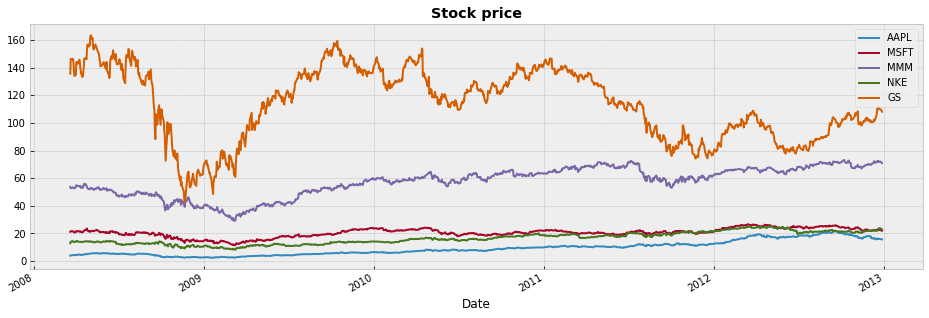

In [12]:
prices.loc[:,selected_companies].plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

In [20]:
prices.index = prices.index.to_period(freq='d')
returns = prices.pct_change().dropna()

returns.head()

AttributeError: 'PeriodIndex' object has no attribute 'to_period'

### Plot histograms

In [ ]:
fig = plt.figure(figsize=(7, 7))

sns.pairplot(returns[selected_companies])

plt.show()

Let's consider a case of equally-weighted portfolio with weights $w_i \sim \frac{1}{p_i}$. This way, price changes of all companies will have the same level of contribution in a change of a portfolio

In [21]:
w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

w_temp = 1 / prices[selected_companies].iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns[selected_companies].values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)
print(w_temp)

AAPL    0.188841
AXP     0.022482
BA      0.013843
CAT     0.015048
CSCO    0.042317
CVX     0.015847
DIS     0.028255
GS      0.005521
HD      0.039677
IBM     0.010398
INTC    0.054113
JNJ     0.017465
JPM     0.025249
KO      0.038657
MCD     0.020968
MMM     0.013931
MRK     0.030466
MSFT    0.035246
NKE     0.057868
PFE     0.066781
PG      0.016790
RTX     0.024239
TRV     0.022859
UNH     0.025372
V       0.058375
VZ      0.045450
WBA     0.028911
WMT     0.020277
XOM     0.014754
Name: 2008-03-19, dtype: float64
AAPL    0.626531
MSFT    0.116939
MMM     0.046221
NKE     0.191992
GS      0.018317
Name: 2008-03-19, dtype: float64


In [22]:
w_temp

AAPL    0.626531
MSFT    0.116939
MMM     0.046221
NKE     0.191992
GS      0.018317
Name: 2008-03-19, dtype: float64

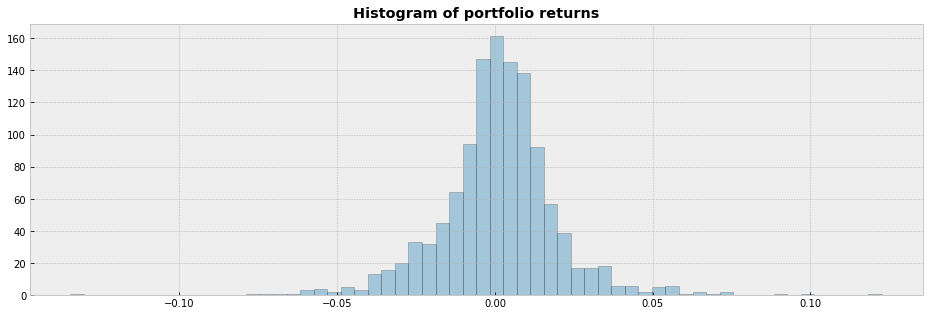

In [23]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of portfolio returns", weight="bold")

plt.show()

And for additional vizualization let's look at join distribution of only two stocks

In [24]:
ticker_one = 'AAPL'
ticker_two = 'MMM'

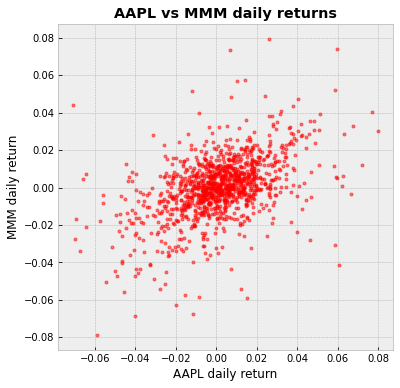

In [25]:
my_lim = 0.08

idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)

x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]

fig = plt.figure(figsize=(6, 6))

plt.plot(x, y, "r.", alpha=0.5)

plt.xlabel("{} daily return".format(ticker_one))
plt.ylabel("{} daily return".format(ticker_two))
plt.title("{} vs {} daily returns".format(ticker_one, ticker_two), weight="bold")

plt.show()

In [26]:
alpha = 0.10

# Important note -- in multivariate case, we cannot take a quantile of some distribution anymore!

Instead, we have to do simulation 

Now even though a portfolo distribution $r^{\text{portfolio}}_t$ is a "univariate random variable", actually it is a weighted sum of several random variables $$ r^{\text{portfolio}}_t = \sum_{j=1}^n w_t^{(j)}r_t^{(j)} = w_t^Tr_t,$$

where each $r_t^{(j)}$ has its own distribution + they could have some correlations, non-linear dependencies etc.


So we:
- fit a joint distribution of $r_t$
- sample from it a lot of pseudo-returns
- multiply it by a vector of weights $w_t^{(j)}$ to get pseudo-portfolio returns
- calculate VaR and ES as quantiles

## Simple models 


### Product of univariate distributions

Let's assume that all $r_t^{(j)}$ are independent and follow t-Student distribution:

$$r_t^{(j)} \sim t(\mu, \sigma^2, df)$$

In [27]:
import scipy.stats as ss

n_samples = 10 ** 4

return_simulations = {}

for col in returns.columns:
    t_df, t_mean, t_sigma = ss.t.fit(returns[col])
    return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

return_simulations.shape

(10000, 29)

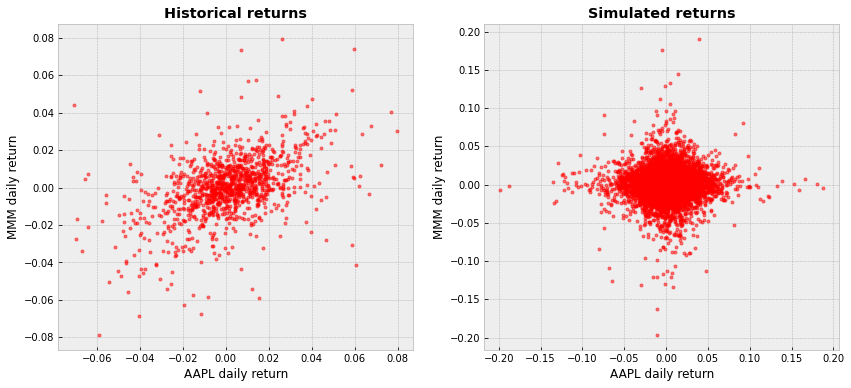

In [28]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.2
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

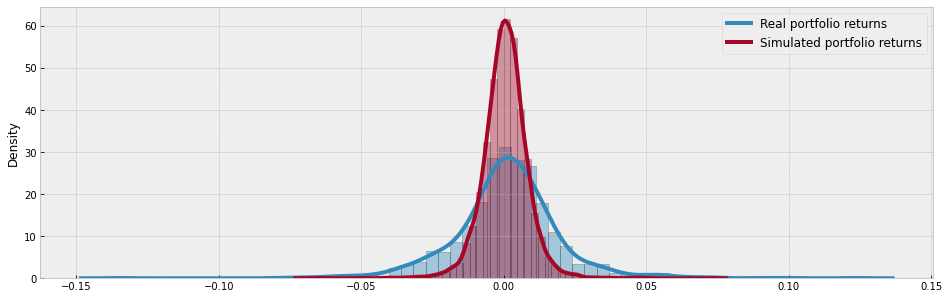

In [29]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [30]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.015860737724571285
-0.008329406555468155


#### Wrapping into functions

In [31]:
def make_dummy_student_simulations(returns, n_samples=10**3):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = ss.t.fit(returns[col])
        return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)
            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)

In [32]:
# VaR_HS = calc_VaR(returns[selected_companies], make_dummy_HS_simulations, w_temp)
VaR_t = calc_VaR(returns[selected_companies], make_dummy_student_simulations, w_temp, level=alpha)

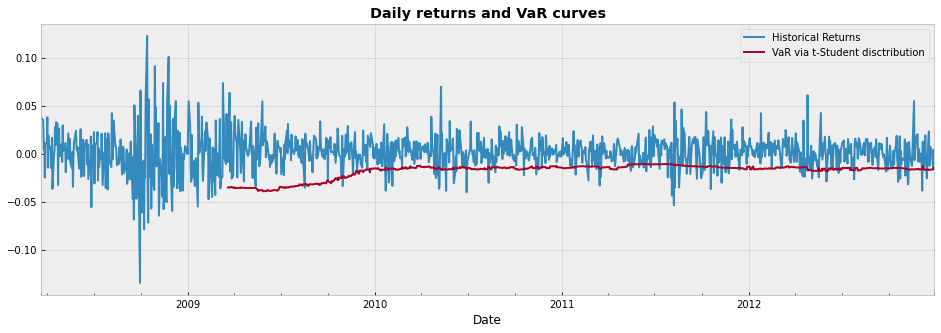

In [33]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_HS.plot()
VaR_t.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'V|aR via Historical Simulation',
            'VaR via t-Student disctribution'])

plt.show()

###  Multivariate Normal distribution

Let's assume that

$$r_t \sim N(\mu, \Sigma)$$


where $\mu \in \mathbb{R}^n$ is a mean vector, $\Sigma$ is a covariance matrix

In [34]:
n_samples = 10 ** 4

# estimate parameters of multivariate normal
mean = np.mean(returns.values, axis=0)
cov = np.cov(returns.values, rowvar=False)

# and sample new pseudo-observations
return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

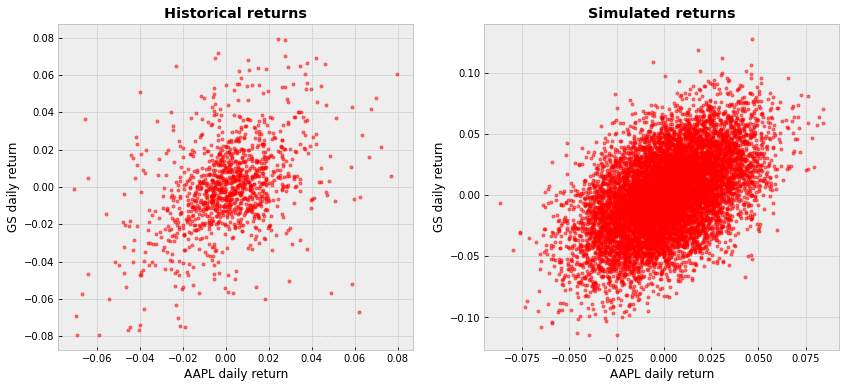

In [35]:
ticker_one = 'AAPL'
ticker_two = 'GS'

fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.2
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

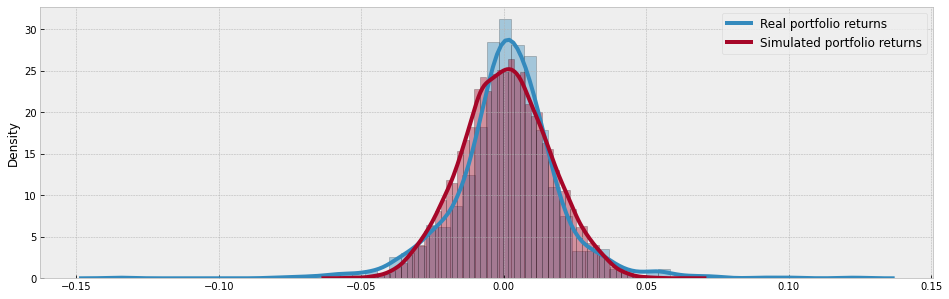

In [36]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [37]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.020966021056945304
-0.019469409264482637


#### Wrapping into functions

In [38]:
def make_mult_normal_simulations(returns, n_samples=10**3):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [39]:
VaR_multy_normal = calc_VaR(returns[selected_companies], make_mult_normal_simulations, w_temp, level=alpha)

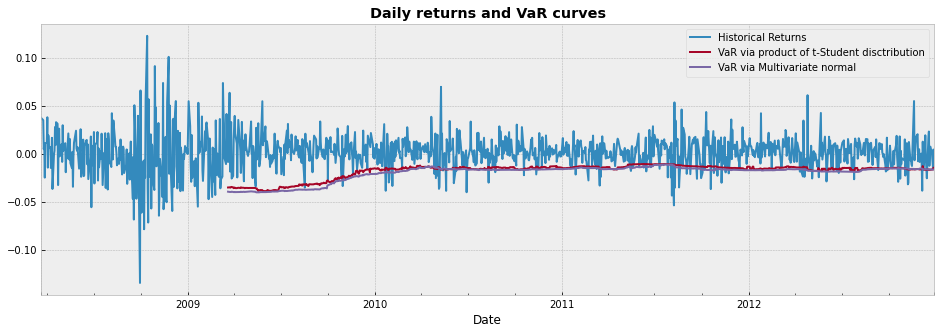

In [40]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_HS.plot()
VaR_t.plot()
VaR_multy_normal.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
#             'VaR via Historical Simulation',
            'VaR via product of t-Student disctribution',
           'VaR via Multivariate normal'])

plt.show()

###  Kernel Density estimation

Here we do not assume any distribution of $r_t$, but trying to estimate the probability density function of a random variable

#### Univariate case

Let's firstly look at univariate case of one $x = r_t^{(j)}$. Let $(x_1, x_2, …, x_m)$ be a univariate independent and identically distributed sample drawn from some distribution with an unknown density $ƒ$. We are interested in estimating the shape of this function $ƒ$. Its kernel density estimator is

$$ \hat{ƒ}(x) = \frac{1}{mh} \sum_{i=1}^m K(\frac{x-x_i}{h})$$

where $K$ is the kernel — a non-negative function — and $h > 0$ is a smoothing parameter called the bandwidth. There are several options for kernel functions, one common is a Gaussian kernel $K(z) = \frac{1}{\sqrt{2\pi}}e^{-z^2/2}$

In [41]:
ret = returns.loc[:, ticker_one].values

kde = ss.gaussian_kde(ret)

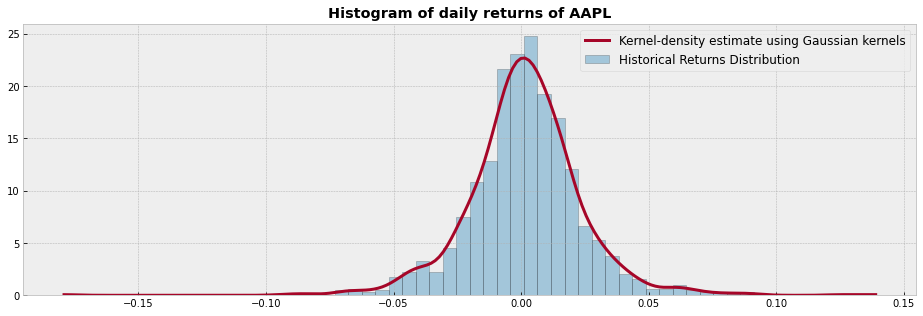

In [42]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = kde.pdf(x)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns of {}".format(ticker_one), weight="bold")
plt.legend(['Kernel-density estimate using Gaussian kernels', 
            'Historical Returns Distribution'], fontsize=12)

plt.show()

#### Multivariate case

In the multivariate case, kernel density estimator is

$$ \hat{ƒ}(x) = \frac{1}{m|H|} \sum_{i=1}^m K(H^{-1}(x-x_i))$$

where $K$ is the kernel and $H$ is a smoothing matrix. Multivariate Gaussian kernel $K(z) = \frac{1}{(2\pi)^{n/2}}e^{\frac{-z^Tz}{2}}$

In [43]:
n_samples = 10 ** 4

# estimate parameters of multivariate normal
kde = ss.gaussian_kde(returns.values.T)

# and sample new pseudo-observations
return_simulations = kde.resample(size=n_samples).T

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

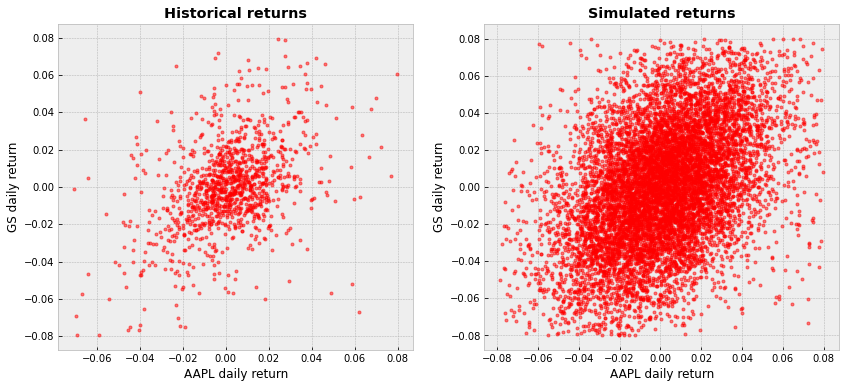

In [44]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.08
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

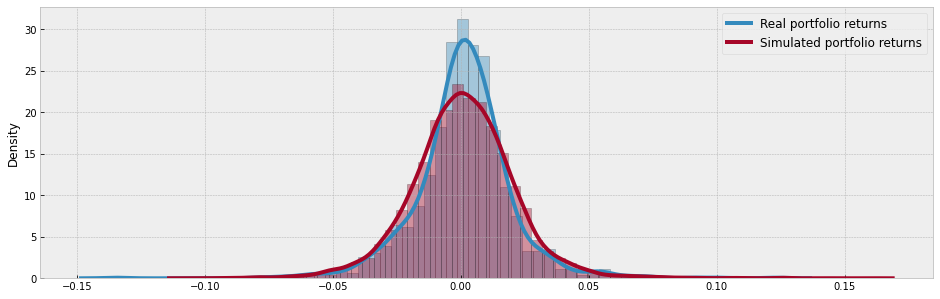

In [45]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [46]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.020966021056945304
-0.023165144592020678


In [47]:
def make_mult_kde_simulations(returns, n_samples=10**3):

    # estimate parameters of multivariate normal
    kde = ss.gaussian_kde(returns.values.T)

    # and sample new pseudo-observations
    return_simulations = kde.resample(size=n_samples).T

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [48]:
VaR_multy_kde = calc_VaR(returns[selected_companies], make_mult_kde_simulations, w_temp, level=alpha)


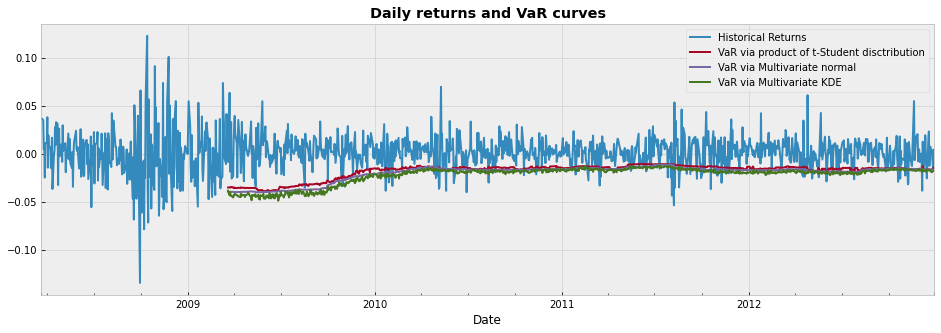

In [49]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_HS.plot()
VaR_t.plot()
VaR_multy_normal.plot()
VaR_multy_kde.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
#             'VaR via Historical Simulation',
            'VaR via product of t-Student disctribution',
           'VaR via Multivariate normal',
           'VaR via Multivariate KDE'
           ])

plt.show()

## Backtesting VaR

In [50]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))


def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [51]:
backtest_results(portfolio_real_returns_selected, VaR_t, alpha)

Target share of violations: 10.00%
Observed share of violations: 9.45%

Test for coverage is passed

Test for independence is passed


In [52]:
backtest_results(portfolio_real_returns_selected, VaR_multy_normal, alpha)

Target share of violations: 10.00%
Observed share of violations: 7.77%

Test for coverage isn't passed

Test for independence is passed


In [53]:
backtest_results(portfolio_real_returns_selected, VaR_multy_kde, alpha)

Target share of violations: 10.00%
Observed share of violations: 6.72%

Test for coverage isn't passed

Test for independence isn't passed
